In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import networkx as nx

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from src.depth import DepthPoset
from src.complexes import CubicalTorusComplex
from src import depth_poset_similarity_scores

import inspect

from tqdm.notebook import tqdm

import itertools

import imageio as io
from PIL import Image

# Cubical Torus

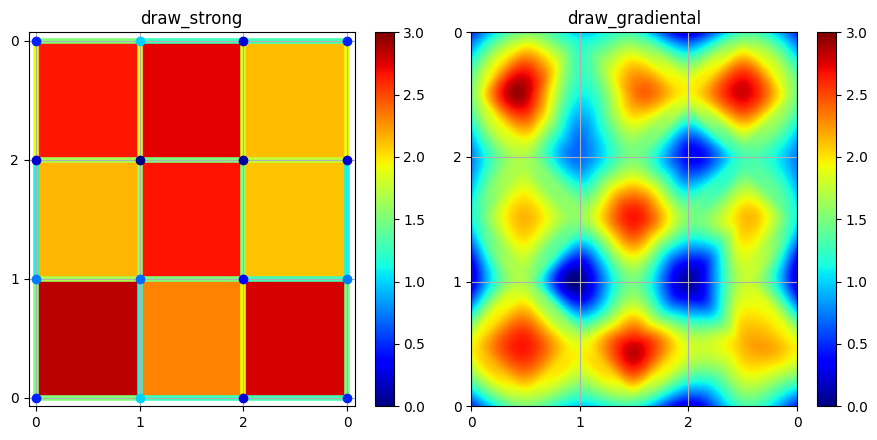

In [3]:
shape = 3, 3

ctc = CubicalTorusComplex(shape)
ctc.assign_random_barycentric_filtration()

if len(shape) == 2:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4.5))

    axs[0].set_title('draw_strong')
    sm0 = ctc.draw_strong(ax=axs[0], vmin=0, vmax=len(shape) + 1)
    axs[1].set_title('draw_gradiental')
    sm1 = ctc.draw_gradiental(ax=axs[1], vmin=0, vmax=len(shape) + 1)

    for i in range(2):
        axs[i].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
        axs[i].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
        axs[i].grid(True)

    eps = 0.07
    axs[0].set_xlim(0 - eps, shape[0] + eps)
    axs[0].set_ylim(0 - eps, shape[1] + eps)

    plt.colorbar(sm0, ax=axs[0])
    plt.colorbar(sm1, ax=axs[1])
    plt.tight_layout()
    plt.show()


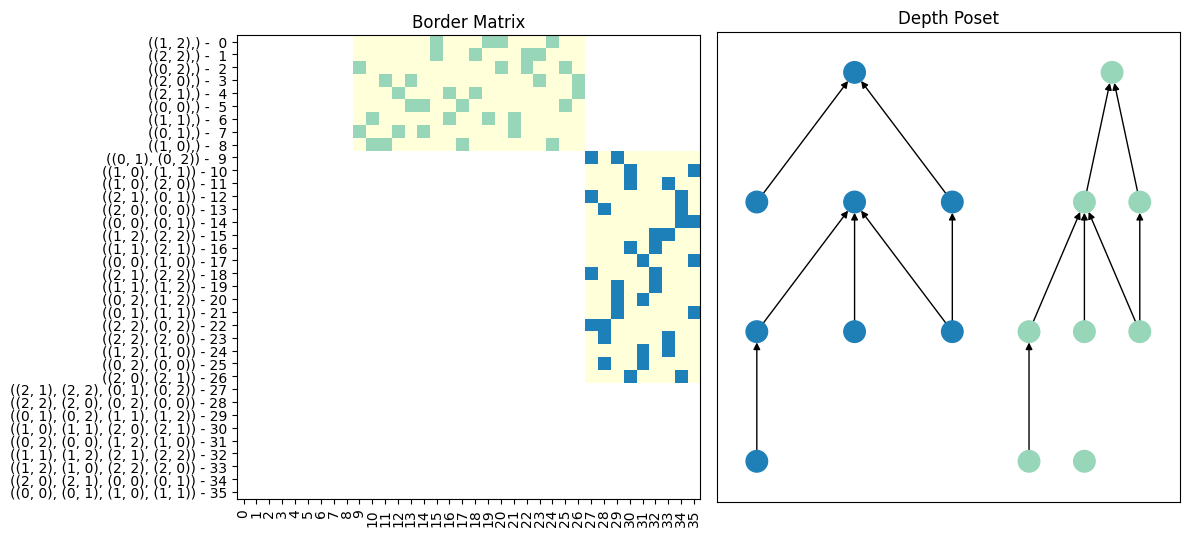

In [4]:
sort_with_filtration = True

order, dims, fvals = ctc.get_order(sort_with_filtration=sort_with_filtration, return_dims=True, return_filtration=True)
bm = ctc.get_border_matrix(sort_with_filtration=sort_with_filtration)
dp = ctc.get_depth_poset(sort_with_filtration=sort_with_filtration)

bm_show = bm.astype(float)*dims
bm_show[dims.reshape(-1, 1) - dims.reshape(1, -1) != -1] = np.nan




fig, axs = plt.subplots(1, 2, figsize=(12, 5.5))
cmap = plt.get_cmap('YlGnBu')

axs[0].set_title('Border Matrix')
axs[0].imshow(bm_show, cmap=cmap, vmax=3)
axs[0].set_yticks(np.arange(len(order)), [f'{val} -{i:>3}' for i, val in enumerate(order)], rotation=0)
axs[0].set_xticks(np.arange(len(order)), np.arange(len(order)), rotation=90)

axs[1].set_title('Depth Poset')
g = dp.get_transitive_reduction()
pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}
nx.draw_networkx(g, pos=pos, node_color=[cmap((node.dim + 1)/(ctc.dim + 1)) for node in dp.nodes], node_size=240,
                 with_labels=False, ax=axs[1])

plt.tight_layout()
plt.show()

# Compare 2 complexes

## Define complexes

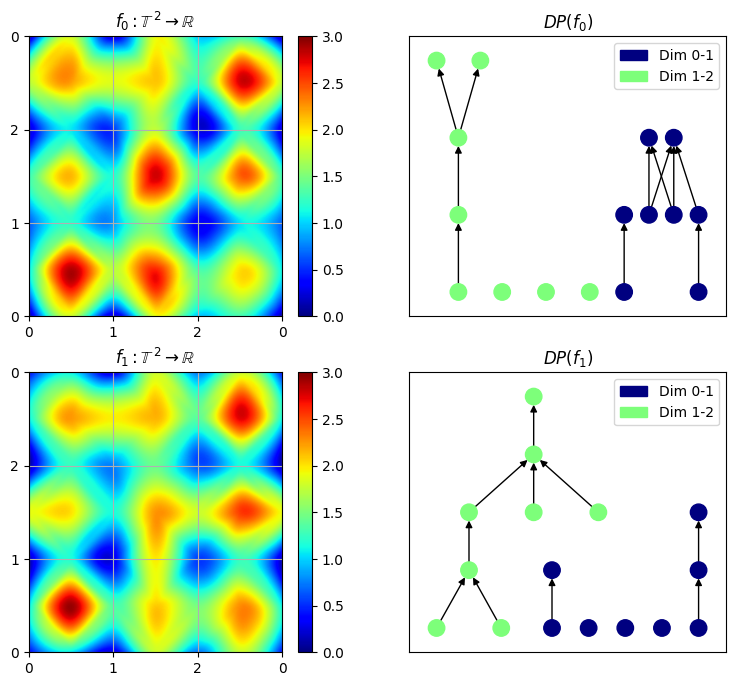

In [5]:
shape = 3, 3

ctc0 = CubicalTorusComplex(shape)
ctc0.assign_random_barycentric_filtration()

ctc1 = CubicalTorusComplex(shape)
ctc1.assign_random_barycentric_filtration()

fvals0 = ctc0.filtration_values
fvals1 = ctc1.filtration_values

t = 0.0
fvals0_new = [m0*(1 - t) + m1*t for m0, m1 in zip(fvals0, fvals1)]
fvals1_new = [m0*t + m1*(1 - t) for m0, m1 in zip(fvals0, fvals1)]
ctc0.assign_filtration(fvals0_new)
ctc1.assign_filtration(fvals1_new)

dp0 = ctc0.get_depth_poset()
dp1 = ctc1.get_depth_poset()

fig, axs = plt.subplots(2, 2, figsize=(9, 8))

cmap_filtration = plt.get_cmap('jet')
cmap_dimensions = plt.get_cmap('jet')
for i, (ctc, dp) in enumerate([(ctc0, dp0), (ctc1, dp1)]):
    axs[i, 0].set_title(f'$f_{i}:\\mathbb{{T}}\\;^{{{len(shape)}}} \\to \\mathbb{{R}}$')
    sm = ctc.draw_gradiental(ax=axs[i, 0], cmap=cmap_filtration, vmin=0, vmax=len(shape) + 1)
    plt.colorbar(sm, ax=axs[i, 0])
    
    axs[i, 0].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
    axs[i, 0].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
    axs[i, 0].grid(True)
    
    
    axs[i, 1].set_title(f'$DP(f_{i})$')
    g = dp.get_transitive_reduction()
    pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}
    nx.draw_networkx(g, pos=pos, node_color=[cmap_dimensions(node.dim/ctc.dim) for node in dp.nodes], node_size=140,
                    with_labels=False, ax=axs[i, 1])
    handles = [mpatches.Patch(color=cmap_dimensions(dim/ctc.dim), label=f"Dim {dim}-{dim + 1}") for dim in range(ctc.dim)]
    axs[i, 1].legend(handles=handles, title=None, loc="best")


## Similarity

In [6]:
sim_scores = [f for _, f in inspect.getmembers(depth_poset_similarity_scores, inspect.isfunction) if inspect.getmodule(f) == depth_poset_similarity_scores]

df_sim = pd.Series({(score.__name__.replace('cell', '').replace('index', '').replace('__', '_'), score.__name__.find('cell') != -1): score(dp0, dp1) for score in sim_scores})
df_sim = df_sim.unstack(level=1).rename(columns={False: 'by indices', True: 'by cells'})
df_sim

,by indices,by cells
birth_relation_similarity,0.000000,0.000000
death_relation_similarity,0.000000,0.000000
poset_arc_similarity,0.000000,0.000000
poset_node_similarity,0.066667,0.103448
relation_similarity,0.000000,0.000000


## Linear Homotopy

In [7]:
def get_cross_parameters(y0, y1, t0=0, t1=1, filter_outside=True):
    """
    Returns the matrix of cross parameters between two arrays.

    Parameters:
        y0, y1: two arrays of the same length
        t0, t1: the time points for the arrays
        filter_outside: if True, filter out the values outside the range [t0, t1]

    Returns:
        cross_parameters: the matrix of cross parameters
    """
    y0 = np.asarray(y0)
    y1 = np.asarray(y1)
    if y0.shape != y1.shape:
        raise ValueError("Arrays must have the same length.")
    if y0.ndim != 1:
        raise ValueError("Arrays must be 1D.")
    
    yi0 = y0.reshape(-1, 1)
    yi1 = y1.reshape(-1, 1)
    yj0 = y0.reshape(1, -1)
    yj1 = y1.reshape(1, -1)

    cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


    if filter_outside:
        cross_parameters[cross_parameters < min(t0, t1)] = np.nan
        cross_parameters[cross_parameters > max(t0, t1)] = np.nan
    return cross_parameters

/tmp/ipykernel_20695/49407725.py:25: RuntimeWarning: invalid value encountered in divide
  cross_parameters = (t1 - t0)*(yj0 - yi0)/(yi1 - yi0 - yj1 + yj0) + t0


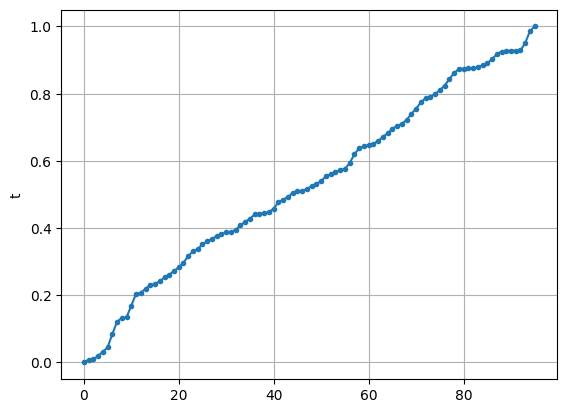

In [8]:
cross_parameters = [get_cross_parameters(m0.flatten(), m1.flatten()) for m0, m1 in zip(fvals0, fvals1)]
#cross_parameters = [m0.flatten()*(1 - t) + m1.flatten()*t for m0, m1, t in zip(fvals0, fvals1, cross_parameters)]
cross_parameters = np.unique(np.concatenate([m.flatten() for m in cross_parameters]))
cross_parameters = np.sort(cross_parameters[~np.isnan(cross_parameters)])

ts = np.unique(np.concatenate([0.5*(cross_parameters[1:] + cross_parameters[:-1]), [0, 1]]))

plt.plot(ts, marker='.')
plt.grid(True)
plt.ylabel('t')
plt.show()

In [9]:
fvals0 = ctc0.filtration_values
fvals1 = ctc1.filtration_values

#ts = np.linspace(0, 1, 11)

ctcs = []
for t in ts:
    fvals_new = [m0*(1 - t) + m1*t for m0, m1 in zip(fvals0, fvals1)]
    
    ctc = CubicalTorusComplex(shape)
    ctc.assign_filtration(fvals_new)
    ctc.assign_random_barycentric_filtration()
    ctcs.append(ctc)

dps = [ctc.get_depth_poset() for ctc in ctcs]



In [10]:
similarity_matrices = {score.__name__: np.array([[score(dp0, dp1) for dp1 in dps] for dp0 in dps]) for score in tqdm(sim_scores)}

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
def get_diff_array(matrix, diff=0):
    # 
    m0 = np.ones(matrix.shape) * np.arange(matrix.shape[0])
    m1 = np.ones(matrix.shape) * np.arange(matrix.shape[1]).reshape(-1, 1)
    diff_array = matrix[m1 - m0 == diff]
    return diff_array

diff_range = np.arange(0, list(similarity_matrices.values())[0].shape[0])

df_diffs = pd.DataFrame(
    {
    (key, f.__name__): [f(get_diff_array(matrix, diff_val)) for diff_val in diff_range] for (key, matrix), f in itertools.product(similarity_matrices.items(), [np.mean, 
                                                                                                                                                                np.max, 
                                                                                                                                                                #np.min, 
                                                                                                                                                                ])
    }, index=diff_range,
)
print(f'df_diffs.shape = {df_diffs.shape}')
df_diffs.head()

df_diffs.shape = (96, 20)


birth_relation_cell_similarity           birth_relation_index_similarity  \
                            mean       max                            mean   
0                       1.000000  1.000000                        1.000000   
1                       0.002012  0.090909                        0.004386   
2                       0.003750  0.100000                        0.003979   
3                       0.002284  0.066667                        0.001216   
4                       0.002530  0.076923                        0.001641   

            death_relation_cell_similarity            \
        max                           mean       max   
0  1.000000                       1.000000  1.000000   
1  0.062500                       0.003822  0.125000   
2  0.083333                       0.002641  0.071429   
3  0.071429                       0.001425  0.076923   
4  0.055556                       0.005575  0.090909   

  death_relation_index_similarity           poset_arc_cell_similarity  \
                             mean       max                      mean   
0                        1.000000  1.000000                  1.000000   
1                        0.003384  0.076923                  0.002092   
2                        0.003858  0.111111                  0.002231   
3                        0.001086  0.055556                  0.001966   
4                        0.004980  0.066667                  0.004249   

            poset_arc_index_similarity           poset_node_cell_similarity  \
        max                       mean       max                       mean   
0  1.000000                   1.000000  1.000000                   1.000000   
1  0.052632                   0.006368  0.100000                   0.079093   
2  0.043478                   0.005756  0.096774                   0.083323   
3  0.045455                   0.002607  0.034483                   0.083280   
4  0.038462                   0.005280  0.076923                   0.083998   

            poset_node_index_similarity           relation_cell_similarity  \
        max                        mean       max                     mean   
0  1.000000                    1.000000  1.000000                 1.000000   
1  0.280000                    0.069939  0.230769                 0.002698   
2  0.280000                    0.069922  0.230769                 0.002928   
3  0.280000                    0.065050  0.230769                 0.002512   
4  0.230769                    0.064266  0.280000                 0.004127   

            relation_index_similarity            
        max                      mean       max  
0  1.000000                  1.000000  1.000000  
1  0.062500                  0.005374  0.083333  
2  0.055556                  0.004478  0.074074  
3  0.052632                  0.001890  0.043478  
4  0.045455                  0.004807  0.062500

In [12]:
df_diffs.columns.get_level_values(0).nunique()

10

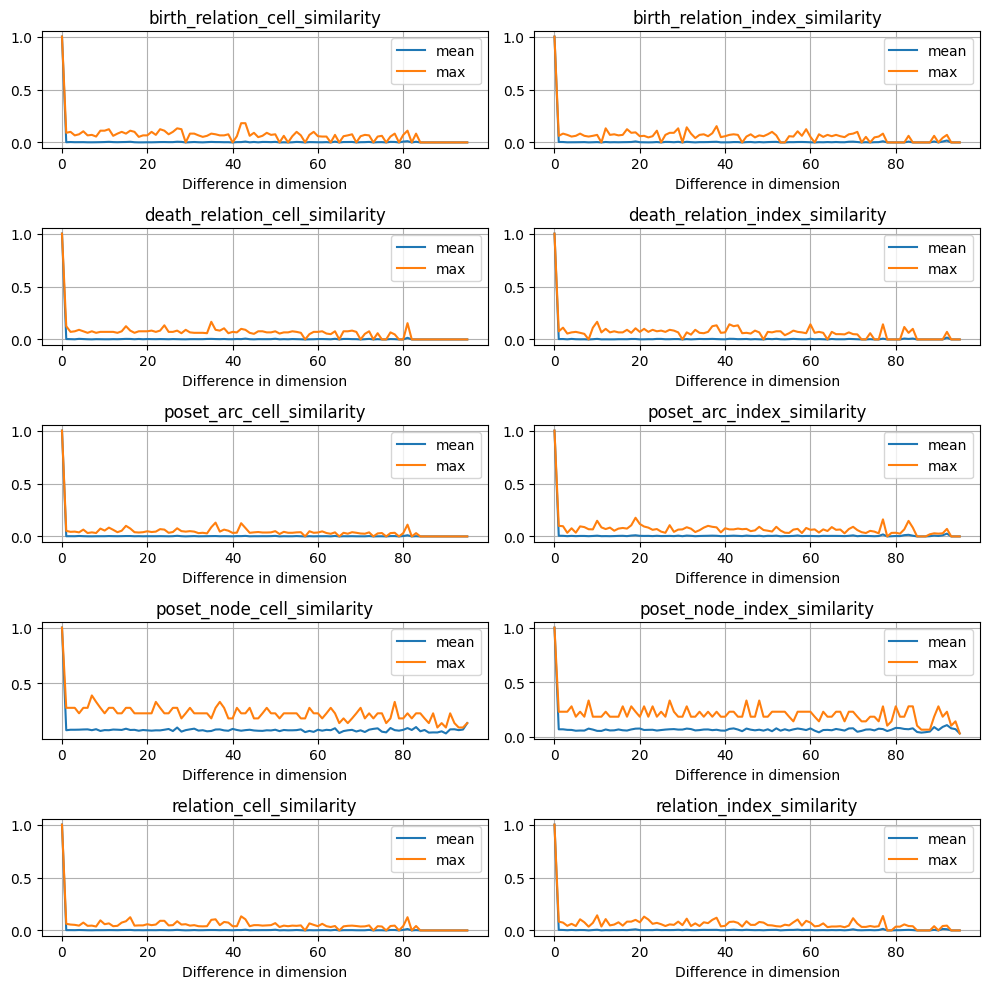

,max,mean
birth_relation_cell_similarity,-0.395285,-0.179675
birth_relation_index_similarity,-0.332761,-0.175113
death_relation_cell_similarity,-0.393427,-0.181963
death_relation_index_similarity,-0.351950,-0.176737
poset_arc_cell_similarity,-0.321036,-0.180718
poset_arc_index_similarity,-0.322547,-0.173068
poset_node_cell_similarity,-0.490964,-0.182696
poset_node_index_similarity,-0.350802,-0.166071
relation_cell_similarity,-0.335670,-0.180938
relation_index_similarity,-0.333106,-0.177643


In [13]:
fig, axs = plt.subplots(df_diffs.columns.get_level_values(0).nunique() // 2, 2, figsize=(10, df_diffs.columns.get_level_values(0).nunique()))
for i, col in enumerate(df_diffs.columns.get_level_values(0).unique()):
    ax = axs[i//2, i%2]
    df_diffs[col].plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Difference in dimension')
    ax.grid(True)
plt.tight_layout()
plt.show()

index_series = pd.Series(df_diffs.index, name="index", index=df_diffs.index)
df_diffs.apply(lambda col: col.corr(index_series)).unstack()


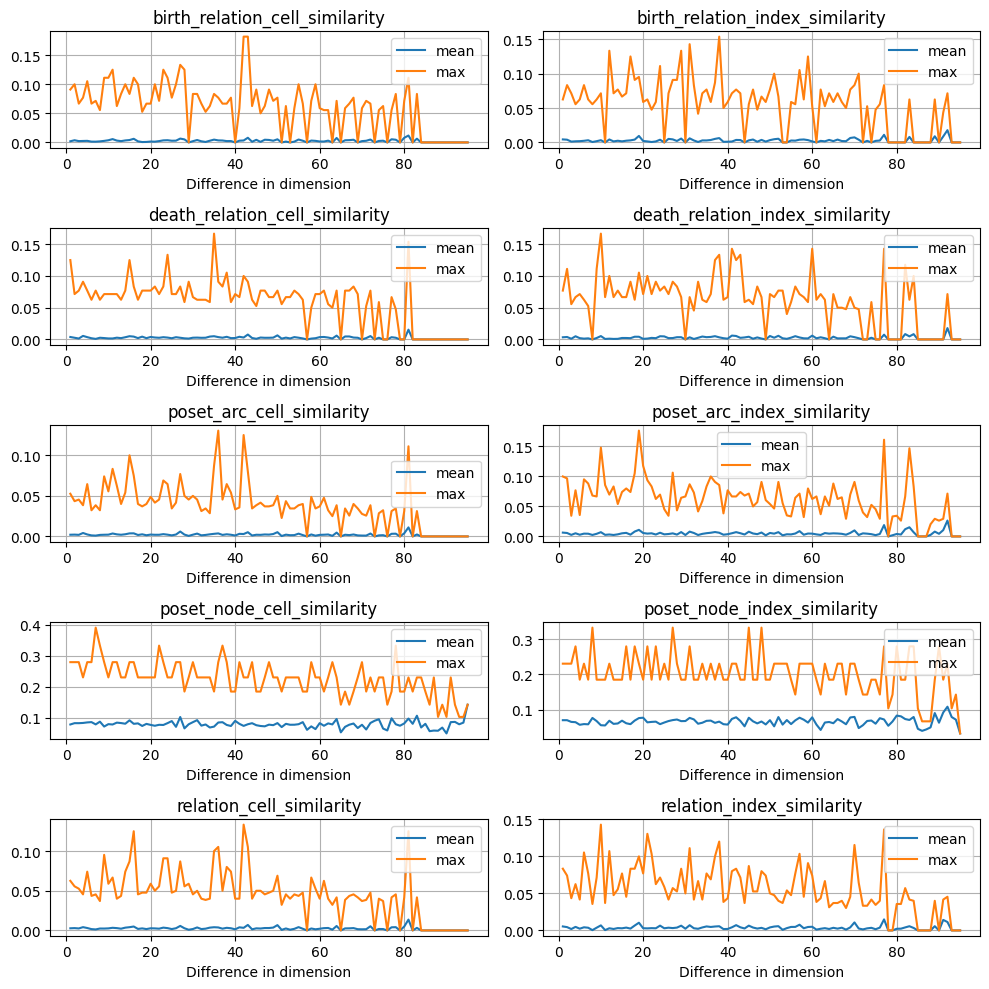

,max,mean
birth_relation_cell_similarity,-0.589038,-0.176133
birth_relation_index_similarity,-0.468374,0.024566
death_relation_cell_similarity,-0.646612,-0.292118
death_relation_index_similarity,-0.495277,-0.037257
poset_arc_cell_similarity,-0.581025,-0.308507
poset_arc_index_similarity,-0.479371,0.074003
poset_node_cell_similarity,-0.621049,-0.066307
poset_node_index_similarity,-0.365622,0.075402
relation_cell_similarity,-0.577974,-0.269125
relation_index_similarity,-0.536430,-0.068256


In [14]:
df_diffs1 = df_diffs.loc[df_diffs.index != 0, :].copy()

fig, axs = plt.subplots(df_diffs1.columns.get_level_values(0).nunique() // 2, 2, figsize=(10, df_diffs1.columns.get_level_values(0).nunique()))
for i, col in enumerate(df_diffs1.columns.get_level_values(0).unique()):
    ax = axs[i//2, i%2]
    df_diffs1[col].plot(ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Difference in dimension')
    ax.grid(True)
plt.tight_layout()
plt.show()

index_series = pd.Series(df_diffs1.index, name="index", index=df_diffs1.index)
df_diffs1.apply(lambda col: col.corr(index_series)).unstack()


In [15]:
ts = np.linspace(0, 1, 501)
ts = np.unique(np.concatenate([0.5*(cross_parameters[1:] + cross_parameters[:-1]), ts]))


imgs = []

cmap = plt.get_cmap('jet')

for t in tqdm(ts):
    fvals_new = [m0*(1 - t) + m1*t for m0, m1 in zip(fvals0, fvals1)]
    
    ctc = CubicalTorusComplex(shape)
    ctc.assign_filtration(fvals_new)
    
    dp = ctc.get_depth_poset()
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    fig.suptitle(f'$t = {t:.6f}$')

    axs[0].set_title(r'Filtration $f_t: \mathbb{T}\;^2 \to \mathbb{R}$')
    sm = ctc.draw_gradiental(ax=axs[0], vmin=0, vmax=len(shape) + 1, cmap=cmap)
    plt.colorbar(sm, ax=axs[0])

    axs[0].set_xticks(np.arange(shape[0] + 1), labels=np.arange(shape[0] + 1)%shape[0])
    axs[0].set_yticks(np.arange(shape[1] + 1), labels=np.arange(shape[1] + 1)%shape[1])
    axs[0].grid(True)


    for i in range(2):
        persistant_plot = i == 0
        title = r'Depth Poset $DP(f_t)$' 
        title += ' (Persistance Diagram)' if persistant_plot else ' (Hasse Diagram)'
        axs[1 + i].set_title(title)
        
        if persistant_plot:
            pos = dp.persistant_layout()
        else: 
            g = dp.get_transitive_reduction()
            pos = {node: (x, -y) for node, (x, y) in nx.nx_agraph.graphviz_layout(g, prog="dot", args='-Grankdir=DU').items()}

        node_colors_birth = [cmap(node.birth_value/(len(shape) + 1)) for node in dp.nodes]
        node_colors_death = [cmap(node.death_value/(len(shape) + 1)) for node in dp.nodes]

        hide_ticks = not persistant_plot
        nx.draw_networkx_edges(dp.get_transitive_reduction(), pos=pos, node_size=140, ax=axs[1 + i], hide_ticks=hide_ticks)
        nx.draw_networkx_nodes(dp.get_transitive_reduction(), pos=pos, node_size=140, node_color=node_colors_death, ax=axs[1 + i], node_shape='o', hide_ticks=hide_ticks)
        nx.draw_networkx_nodes(dp.get_transitive_reduction(), pos=pos, node_size=140, node_color=node_colors_birth, ax=axs[1 + i], node_shape='*', hide_ticks=hide_ticks)
        
        if persistant_plot:
            axs[i+1].fill_between([0, len(shape) + 1], [0, 0], [0, len(shape) + 1], color='silver')

            axs[1 + i].set_xticks(np.arange(0, len(shape) + 1, 1))
            axs[1 + i].set_yticks(np.arange(1, len(shape) + 2, 1))
            eps = 0.1
            axs[1 + i].set_xlim(0 - eps, len(shape) + eps)
            axs[1 + i].set_ylim(1 - eps, len(shape) + 1 + eps)

            axs[1 + i].set_xlabel('Birth Value')
            axs[1 + i].set_ylabel('Death Value')

            axs[1 + i].grid(True)

    plt.tight_layout()

    # draw, save, close and delete
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8').reshape(height, width, 4)
    img = Image.fromarray(image[..., :3])  
    


    imgs.append(img)
    plt.close('all')
    del fig

filename = f'gifs/homotopy on torus.gif'

io.mimsave(filename, imgs, fps=12, loop=0)
print(f'generated and saved to path {filename}')
    

  0%|          | 0/595 [00:00<?, ?it/s]

generated and saved to path gifs/homotopy on torus.gif
